# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-2.0478],
         [ 0.4308]]),
 tensor([[ 1.0000e+00, -2.0478e+00,  2.0967e+00, -1.4312e+00,  7.3270e-01,
          -3.0008e-01,  1.0242e-01, -2.9962e-02,  7.6694e-03, -1.7450e-03,
           3.5734e-04, -6.6524e-05,  1.1352e-05, -1.7882e-06,  2.6157e-07,
          -3.5709e-08,  4.5702e-09, -5.5052e-10,  6.2631e-11, -6.7502e-12],
         [ 1.0000e+00,  4.3078e-01,  9.2786e-02,  1.3323e-02,  1.4349e-03,
           1.2362e-04,  8.8756e-06,  5.4620e-07,  2.9412e-08,  1.4078e-09,
           6.0644e-11,  2.3749e-12,  8.5256e-14,  2.8251e-15,  8.6929e-17,
           2.4965e-18,  6.7214e-20,  1.7032e-21,  4.0762e-23,  9.2417e-25]]),
 tensor([-12.6016,   5.2345]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 5.0102367  1.1926025 -3.4063559  5.6025686]]


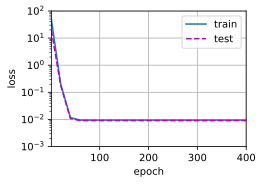

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[2.596904 5.658805]]


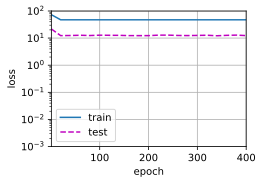

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 5.0215492e+00  1.2597891e+00 -3.4725826e+00  5.2711573e+00
   1.7769295e-01  7.6166785e-01  3.3560574e-01  1.2097979e-01
   5.8379386e-02 -7.5341560e-02  1.2725668e-01 -4.2431410e-02
   4.2648274e-02  1.0250626e-01 -1.6302970e-01  7.5756460e-02
  -1.3615482e-01  3.1125725e-03  4.8235103e-02 -1.8000999e-01]]


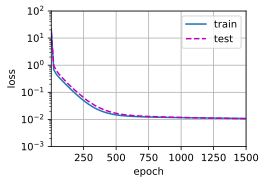

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)